# 一个小目标 mission four
---


## 任务
记录五个模型关于precision，rescore，f1，auc，roc的评分表格，画出auc和roc曲线图


In [1]:
# 导入需要的包
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, classification_report


# 设置 pandas 显示列数
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)

## 1. 导入数据

In [48]:
# 因为数据并非utf-8编码，要使用gbk编码读入，否则出错
data = pd.read_csv('./data/data.csv', index_col=0, encoding='gbk')

# 观察数据构成
# data.head()
print(data.shape)

(4754, 89)


In [3]:
# 划分 X, y
y = data['status']
X = data.drop('status', axis=1)

# X行数
print('X.shape:', X.shape)
print('y 的分布\n', y.value_counts())

X.shape: (4754, 88)
y 的分布
 0    3561
1    1193
Name: status, dtype: int64


## 2. 数据探索及特征处理
本次任务目的在于主流程，所以数据探索部分做得比较粗糙，以后有需要再慢慢补充
从上面数据看出，本份数据以数值型特征位数，有少数几个字符型特征，还有两个日期特征。下面一步步进行处理

In [4]:
# 首先剔除一些明显无用的特征，如 id_name, custid, trade_no, bank_card_no，
# 这些优点类似一个人的唯一信息，如果加入模型训练且对最终模型生效的话，很可能就是出现了过拟合
X.drop(['id_name', 'custid', 'trade_no', 'bank_card_no'], axis=1, inplace=True)

# 数值型变量
X_num = X.select_dtypes('number').copy()
# student_feature
X_num.fillna({'student_feature': 0}, inplace=True)
# 其他数值型变量使用均值代替
X_num.fillna(X_num.mean(), inplace=True)

# 字符型变量
X_str = X.select_dtypes(exclude='number').copy()
X_str_dummy = pd.get_dummies(X_str['reg_preference_for_trad'])

# 合并
X_cl = pd.concat([X_num, X_str_dummy], axis=1, sort=False)
X_cl.shape

(4754, 85)

### 3. 数据划分
三七 分，随机种子就取今天日期吧

In [5]:
random_state = 1115
X_train, X_test, y_train, y_test = train_test_split(X_cl, y, test_size=0.3, random_state=random_state)
print(X_train.shape)
print(X_test.shape)

(3327, 85)
(1427, 85)


In [6]:
# 数据归一化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

### 4. 建模
#### model1-LR

In [28]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.05, penalty='l1')
lr.fit(X_train_std, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### model2-svm

In [27]:
from sklearn.svm import SVC
# 线性 SVM
linear_svc = SVC(kernel='linear', probability=True)
linear_svc.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# 多项式 SVM
poly_svc = SVC(kernel='poly', probability=True)
poly_svc.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### model3-决策树

In [29]:
from sklearn.tree import DecisionTreeClassifier
# 决策树
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### model4-XGBoost

**安装**

安装包路径：https://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost

找到合适的包，使用pip安装。如 pip install xgboost-0.81-cp27-cp27m-win_amd64.whl

**使用**

下面所说仅仅是普通调用，然而 XGB 有很多超参数需要调整，而且这些超参对结果会产生很大的影响，这次先不展开阐述。

参考：[XGBoost使用教程（纯xgboost方法）](https://blog.csdn.net/u011630575/article/details/79418138)

In [30]:
# xgbboost
from xgboost.sklearn import XGBClassifier
xgb_params = {
    'learning_rate': 0.1,
    'n_estimators': 42,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 112
}
xgb_model = XGBClassifier(**xgb_params) # 迭代次数(n_estimators)已经是超参之一

# 训练
xgb_model.fit(X_train_std, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=42,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=112,
       silent=True, subsample=0.8)

#### model5-LightGBM

**安装**

使用 pip install lightgbm 直接安装

**使用**

这里的用法与xgb的非常类似

参考：[【集成学习】lightgbm使用案例](https://www.cnblogs.com/wanglei5205/p/8654041.html)

In [31]:
# lightgbm
from lightgbm.sklearn import LGBMClassifier
lgb_params  = {
    'learning_rate': 0.1,
    'n_estimators': 42,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary', # 这里和 xgb 不一样
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 112
}
lgb_model = LGBMClassifier(**lgb_params) # 迭代次数(n_estimators)已经是超参之一

# 训练
lgb_model.fit(X_train_std, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        gamma=0, importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
        n_estimators=42, n_jobs=-1, nthread=4, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, scale_pos_weight=1, seed=112, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

## 5. 评估

In [39]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
# 定义评估函数
def model_metrics(clf, X_train, X_test, y_train, y_test):
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

    # 评估
    # 准确性
    print('准确性：')
    print('Train：{:.4f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(accuracy_score(y_test, y_test_pred)))

    # 召回率
    print('召回率：')
    print('Train：{:.4f}'.format(recall_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(recall_score(y_test, y_test_pred)))
    
    # f1_score
    print('f1_score：')
    print('Train：{:.4f}'.format(f1_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(f1_score(y_test, y_test_pred)))
    
    # roc_auc
    print('roc_auc：')
    print('Train：{:.4f}'.format(roc_auc_score(y_train, y_train_pred_proba)))
    print('Test：{:.4f}'.format(roc_auc_score(y_test, y_test_pred_proba)))    
    
    # 描绘 ROC 曲线
    fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_te, tpr_te, _ = roc_curve(y_test, y_test_pred_proba)

    # KS
    print('KS：')
    print('Train：{:.4f}'.format(max(abs((fpr_tr - tpr_tr)))))
    print('Test：{:.4f}'.format(max(abs((fpr_te - tpr_te)))))

    # 绘图
    plt.plot(fpr_tr, tpr_tr, 'r-',
             7label="Train:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_train, y_train_pred_proba), 
                                                        max(abs((fpr_tr - tpr_tr)))))
    plt.plot(fpr_te, tpr_te, 'g-',
             label="Test:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_test, y_test_pred_proba),
                                                     max(abs((fpr_tr - tpr_tr)))))
    plt.plot([0, 1], [0, 1], 'd--')
    plt.legend(loc='best')
    plt.title("ROC curse")
    plt.show()

准确性：
Train：0.7986
Test：0.8031
召回率：
Train：0.3198
Test：0.3324
f1_score：
Train：0.4444
Test：0.4565
roc_auc：
Train：0.8010
Test：0.7911
KS：
Train：0.4564
Test：0.4576


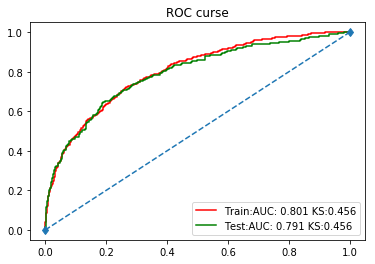

In [40]:
# 逻辑回归
model_metrics(lr, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.7944
Test：0.7975
召回率：
Train：0.2542
Test：0.2676
f1_score：
Train：0.3838
Test：0.3967
roc_auc：
Train：0.8082
Test：0.7894
KS：
Train：0.4796
Test：0.4575


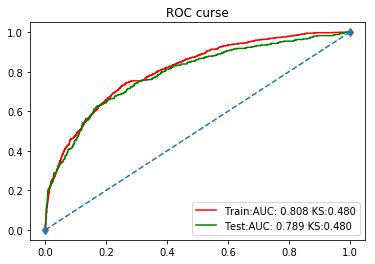

In [44]:
# 线性 SVM
model_metrics(linear_svc, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.8245
Test：0.7687
召回率：
Train：0.3079
Test：0.1577
f1_score：
Train：0.4691
Test：0.2534
roc_auc：
Train：0.9511
Test：0.7172
KS：
Train：0.8093
Test：0.3552


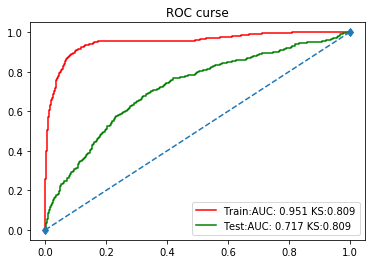

In [43]:
# 多项式 SVM
model_metrics(poly_svc, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.8777
Test：0.7526
召回率：
Train：0.6539
Test：0.4085
f1_score：
Train：0.7292
Test：0.4510
roc_auc：
Train：0.9016
Test：0.6573
KS：
Train：0.6550
Test：0.3018


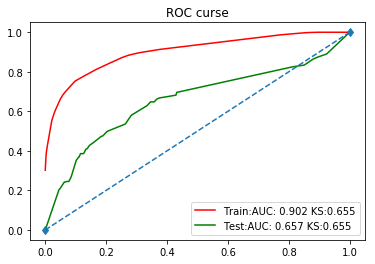

In [45]:
# 决策树
model_metrics(dt, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.8798
Test：0.7940
召回率：
Train：0.5644
Test：0.3690
f1_score：
Train：0.7028
Test：0.4712
roc_auc：
Train：0.9525
Test：0.7932
KS：
Train：0.7644
Test：0.4342


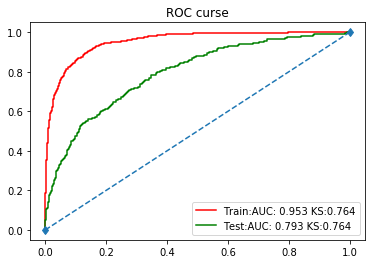

In [46]:
# xgboost
model_metrics(xgb_model, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.8843
Test：0.7996
召回率：
Train：0.5776
Test：0.3634
f1_score：
Train：0.7154
Test：0.4743
roc_auc：
Train：0.9571
Test：0.7991
KS：
Train：0.7776
Test：0.4548


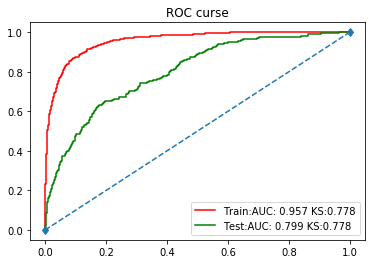

In [47]:
# lightgbm
model_metrics(lgb_model, X_train_std, X_test_std, y_train, y_test)